In [1]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

c:\Users\iks15\Anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_size = 224 # 직접설계한 CNN일 땐 227를 사용하고, 나머지 모델에 대해선 224를 사용한다.

trans = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
])
test_set = torchvision.datasets.ImageFolder('dataset/test',transform=trans)
test_loader = DataLoader(test_set) # 테스트 데이터를 input_size로 resize한 후 가져온다.

model = torch.load('best_model.pt') # 가장 잘 학습된 6 class classifier 모델을 가져온다.
binary_model = torch.load('best_model_binary.pt') # 가장 잘 학습된 binary class classifier 모델을 가져온다.

model.eval()
binary_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
num_correct = 0
all_result = []

# 불러온 모델을 이용하여 테스트를 진행한다.
for x, y in tqdm(test_loader):
    x = x.to(device)
    y = y.to(device)
    
    output = model(x)
    binary_output = binary_model(x)
    
    is_trash = torch.argmax(binary_model(x), 1)
    prediction = torch.argmax(output, 1)
    
    if is_trash[0] == 1: # binary classifier를 적용하지 않은 상태로 테스트 하고 싶으면 이 if문 전체를 주석처리하면 된다.
        # print(torch.max(torch.softmax(binary_output, 1)))
        # print(torch.max(torch.softmax(output, 1)), test_set.classes[prediction[0]], test_set.classes[y[0]])
        prediction[0] = 5
    
    if prediction == y:
        num_correct += 1
    
    all_result.append([y.cpu().detach().numpy()[0], prediction.cpu().detach().numpy()[0]])

accuracy = num_correct / len(test_loader)


100%|██████████| 513/513 [00:15<00:00, 33.10it/s]


Overall Accuracy: 0.847953216374269
--------------------------------
cardboard Accuracy: 0.8481012658227848
glass Accuracy: 0.8105263157894737
metal Accuracy: 0.8536585365853658
paper Accuracy: 0.8512396694214877
plastic Accuracy: 0.9090909090909091
trash Accuracy: 0.7567567567567568


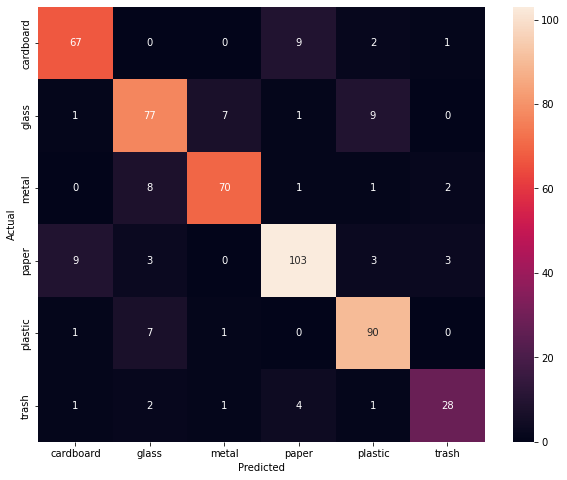

In [4]:
# 테스트 결과를 수치와, heatmap으로 시각화 하여 보여준다.
num_classes = len(test_set.classes)
cmt = np.zeros((num_classes, num_classes), np.int64)

for actual, predicted in all_result:
    cmt[actual, predicted] += 1

plt.figure(figsize=(10,8))
sns.heatmap(cmt, xticklabels=test_set.classes, yticklabels=test_set.classes, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

print('Overall Accuracy:', accuracy)
print('--------------------------------')
for i in range(num_classes):
    per_class_acc = cmt[i, i] / cmt[i].sum()
    print(f"{test_set.classes[i]} Accuracy:", per_class_acc)
